<a href="https://colab.research.google.com/github/PawelJakubczyk/ham_or_spam_classifier/blob/main/spam_or_ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup: Install Required Libraries
<a id="section1"></a>

In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
# %pip install googletrans
%pip install concurrent

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15715 sha256=bc0cac4fe85a3c6fe49d469dc0879b36c49e99123d30a94426cf59ce85481eda
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling cha

# Import Libraries
<a id="section2"></a>

In [ ]:
import json
import string
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# import en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
# stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation as LDA
# nltk.download('all')
from nltk import pos_tag
import joblib



# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [ ]:
# Typing
from typing import Set
# Data libraries
import numpy as np
import pandas as pd
# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
# Data preprocessing
from nltk import download, word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# from googletrans import Translator
from re import sub
import string
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from concurrent.futures import ProcessPoolExecutor

# Define Functions

### Data Analize

In [ ]:
def analyze_word_frequency_in_df_column(df: pd.DataFrame, column_name: str, top_num: int) -> dict:
    download('punkt')
    all_text = ' '.join(df[column_name].tolist())
    words = word_tokenize(all_text)
    fdist = FreqDist(words)
    most_common_words = dict(fdist.most_common(top_num))

    return most_common_words

### Data cleaning

1. **replace_tabs_enters_and_spaces(input_string:str) -> str**:
   This function takes an input string and replaces tabs with a single space and multiple consecutive spaces with a single space.

2. **remove_stopwords(input_string: str, stop_words: Set[str]) -> str**:
   This function removes stopwords from the input string. Stopwords are commonly used words (e.g., "the", "is", "in") that do not carry significant meaning.

3. **remove_affixes(input_string: str, stemmer: PorterStemmer) -> str**:
   This function removes affixes (prefixes and suffixes) from words in the input string using stemming. Stemming reduces words to their root or base form.

4. **lemmatize(text: str) -> str**:
   This function lemmatizes the input text. Lemmatization is similar to stemming but considers the context of the word to determine its base or dictionary form.

5. **stemming(text: str) -> str**:
   This function performs stemming on the input text. Stemming reduces words to their root or base form, often by removing suffixes.

6. **remove_pos_tags(text: str) -> str**:
   This function removes all words from the input text except for nouns (NN). It relies on part-of-speech tagging to identify and retain only nouns in the text.


In [ ]:
def replace_tabs_enters_and_spaces(input_string:str) -> str:
    """Replaces tabs with a single space and multiple spaces with a single space in the input string"""
    replaced_tabs = sub(r'\t', ' ', input_string)
    replace_enters = sub(r'\n', ' ', replaced_tabs)
    replaced_spaces = sub(r'\s+', ' ', replace_enters)
    return replaced_spaces

def remove_stopwords(input_string: str, stop_words: Set[str]) -> str:
    """Removes stopwords from the input string"""
    words = input_string.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_affixes(input_string: str, stemmer: PorterStemmer) -> str:
    """Removes affixes from the input string using stemming"""
    words = word_tokenize(input_string)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def lemmatize(text: str)-> str:
    """Lemmatizes the input text"""
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
    return ' '.join(sent)

def stemming(text: str)-> str:
    """Performs stemming on the input text"""
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in tokens if word.text.lower() not in STOP_WORDS]
    return ' '.join(stem_words)

def remove_pos_tags(text: str)-> str:
    """Removes all words except nouns (NN) from the input text"""
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

### Data Translate

In [ ]:
def translate_to_english(input_string:str) -> str:
    """Translates the input string to English using the Google Translate API."""
    translator = Translator()
    try:
        return translator.translate(input_string, dest='en').text
    except Exception:
        print(f"Translation Error: {Exception}")
    return input_string

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub('\S*\d\S*\s*','', text)
    text = re.sub('\[.*\]','', text)

    return text

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in STOP_WORDS]

    return filtered_tokens

def tokenize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)

    return tokens





def remove_punctuation(input_string: str) -> str:
    """Removes punctuation from the input string"""
    return input_string.translate(str.maketrans('', '', string.punctuation))

def preprocess_text_parallel(text: str) -> str:
    text = replace_tabs_enters_and_spaces(text)
    text = remove_stopwords(text, stop_words=set(stopwords.words('english')))
    text = remove_affixes(text, stemmer=PorterStemmer())
    text = remove_punctuation(text)
    text = translate_to_english(text)
    return text

# Read the spam data from a CSV file

In [ ]:
dtype_dict = {'Message': str, 'Category': str}
spam_df=pd.read_csv('/content/spam.csv', dtype=dtype_dict)

# Data Analisis

# Data Factoring

In [ ]:
download('punkt')
download('stopwords')

with ProcessPoolExecutor() as executor:
    spam_df['Message'] = list(executor.map(preprocess_text_parallel, spam_df['Message']))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
spam_df.head()

,Category,Message
0,ham,go jurong point crazi avail bugi n great wor...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah think goe usf live around though


In [ ]:
print(spam_df.shape)

(5572, 2)


In [ ]:
spam_df.head()

,Category,Message
0,ham,go jurong point crazi avail bugi n great wor...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah think goe usf live around though


Text(0.5, 1.0, 'Distribution of missing values')

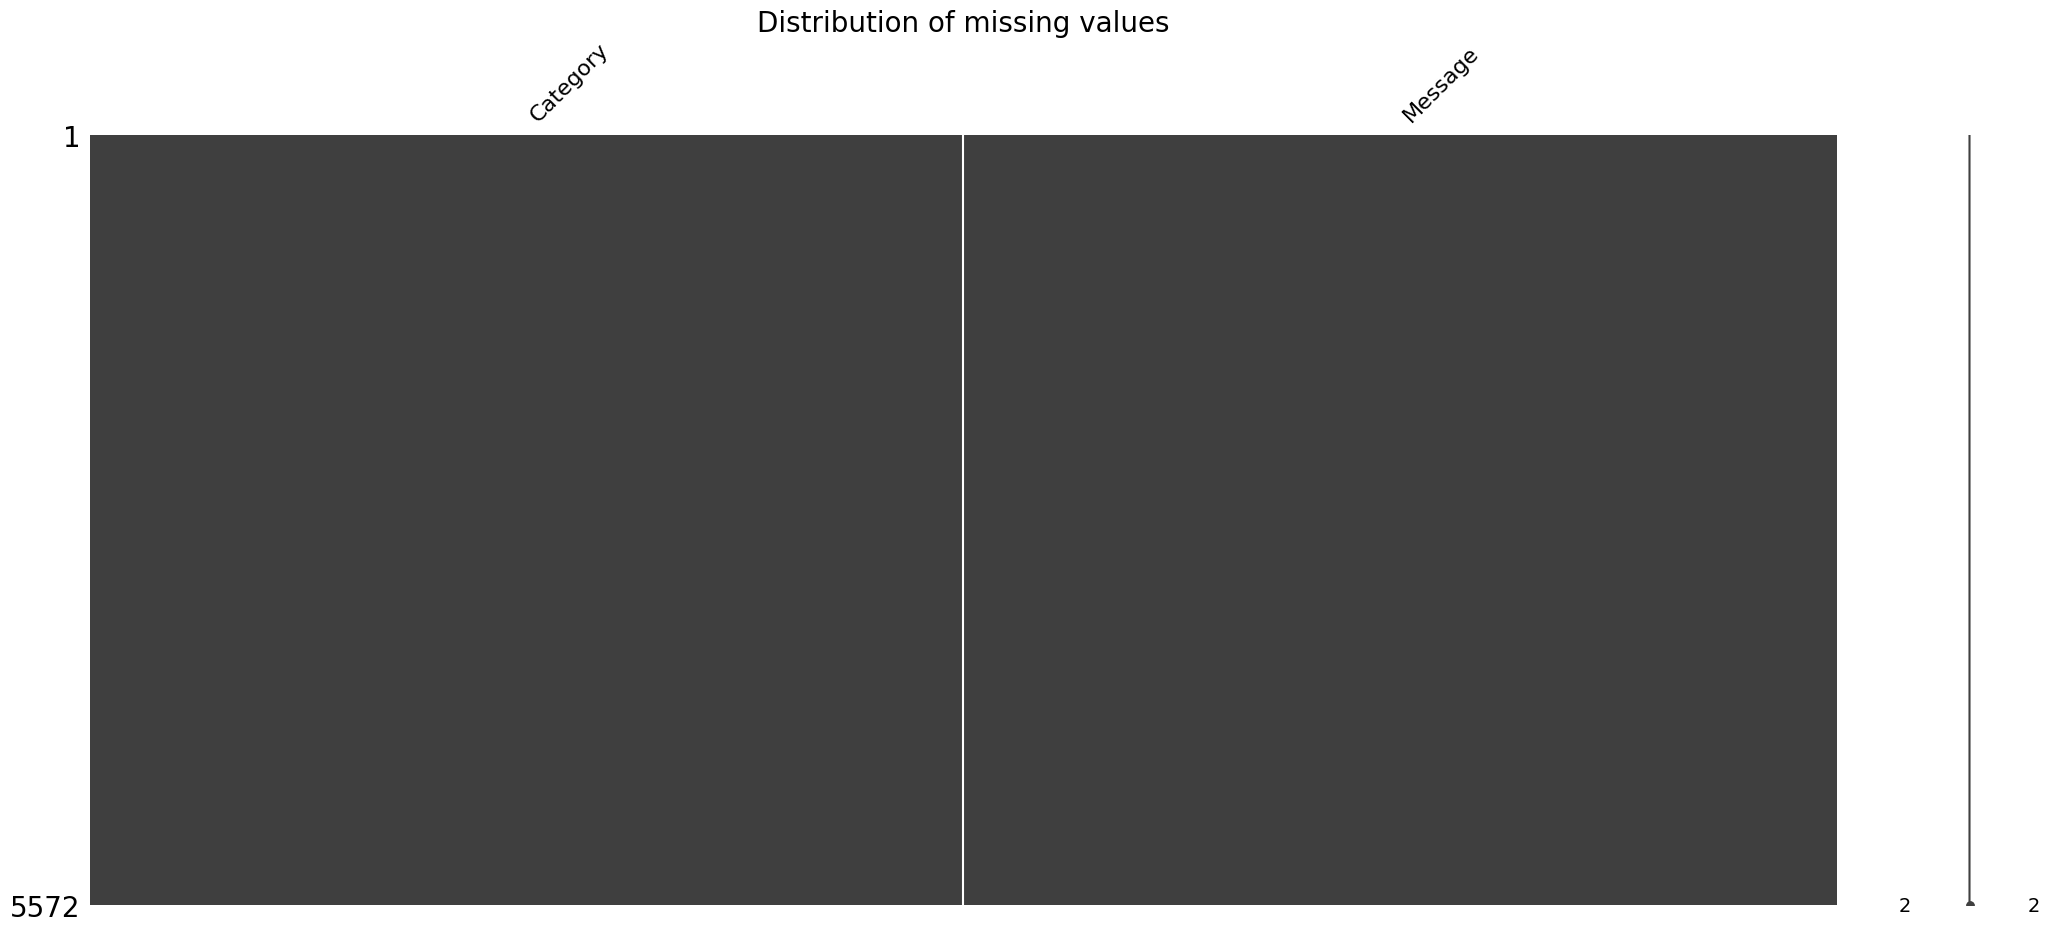

In [ ]:
msno.matrix(spam_df).set_title('Distribution of missing values',fontsize=20)

In [ ]:
# No missing value in the dataframe

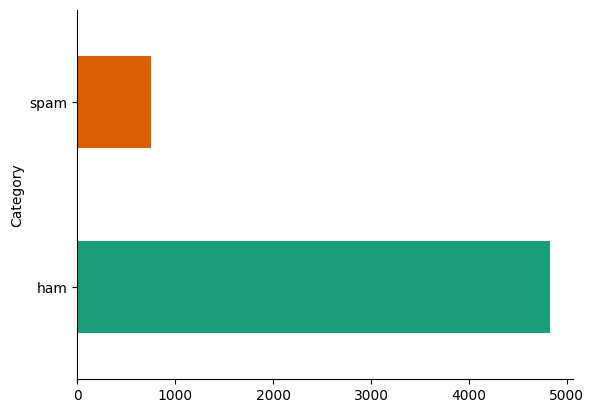

In [ ]:
# Plot the number of occurrences for each category
spam_df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Data Enginering

## Remove specjal char

## Translate all message to english

In [ ]:
spam_df['Message'] = spam_df['Message'].apply(translate_to_english)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spam_df.Message, spam_df.Category, test_size=0.25)

NameError: ignored

In [ ]:
# Create a pipeline for the model
clf=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('nb',MultinomialNB())
])

In [ ]:
# Fit the model on the training data
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

In [ ]:
# Predict the categories for the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Percentage coverage: {accuracy * 100}%")

Procent pokrycia: 98.77961234745155%
